# Gradient Descent Regression Demo — Boston Housing Dataset (From Scratch)

This notebook demonstrates **gradient descent optimization implemented entirely from scratch** using the `rice_ml` package.

We apply gradient descent to a **linear regression model** trained on the Boston Housing dataset, a classic benchmark for regression tasks.

In this notebook, we will:

- Load and inspect the Boston Housing dataset
- Perform exploratory data analysis (EDA)
- Standardize features using our own preprocessing utilities
- Train a linear regression model using gradient descent
- Evaluate performance using regression metrics
- Visualize convergence behavior and residuals

No external machine learning libraries (e.g. sklearn) are used.

## Boston Housing Dataset

The Boston Housing dataset contains information about housing values in suburbs of Boston.

Each observation corresponds to a census tract and includes **13 numerical features** describing socioeconomic and environmental factors.

### Features

| Feature | Description |
|-------|-------------|
| CRIM | Per capita crime rate |
| ZN | Proportion of residential land zoned |
| INDUS | Proportion of non-retail business acres |
| CHAS | Charles River dummy variable (0 or 1) |
| NOX | Nitric oxides concentration |
| RM | Average number of rooms |
| AGE | Proportion of owner-occupied units built prior to 1940 |
| DIS | Weighted distances to employment centers |
| RAD | Index of accessibility to highways |
| TAX | Property tax rate |
| PTRATIO | Pupil-teacher ratio |
| B | Proportion of Black population |
| LSTAT | Percentage of lower-status population |

### Target

- **MEDV** — Median value of owner-occupied homes (in \$1000s)

All variables are numeric.  
The dataset does not contain missing values.


## Imports and Set Up

Import Numpy, Matplotlib, Pandas, and custom functions from preprocessing.py and post_processing.py

In [24]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# Import preprocessing utilities
from rice_ml.processing.preprocessing import minmax_scale, standardize, train_test_split
from rice_ml.processing.post_processing import r2_score

# Import Gradient Descent classes
from rice_ml.supervised_learning.gradient_descent import (
    GradientDescent1D, GradientDescentND
)

## Data Loading

We load the Boston Housing dataset directly from the UCI Machine Learning Repository.
The data is provided as a whitespace-separated file without headers, so we manually assign column names.

In [25]:
# Upload Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
column_names = [
    "CRIM",
    "ZN",
    "INDUS",
    "CHAS",
    "NOX",
    "RM",
    "AGE",
    "DIS",
    "RAD",
    "TAX",
    "PTRATIO",
    "B",
    "LSTAT",
    "MEDV",
]

import pandas as pd
df = pd.read_csv(url, delim_whitespace=True, names=column_names)

df.head()

/var/folders/c5/0_7ty6x134d18k3dbht20_l80000gn/T/ipykernel_85827/3713877068.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, names=column_names)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Exploratory Data Analysis (EDA)

Before modeling, we explore the dataset to understand:

- Feature distributions
- Target variable behavior
- Scale differences across variables

This step helps motivate feature standardization and gradient descent optimization.

### Target Distribution

We first examine the distribution of housing prices.

### Feature Scale Differences

Gradient descent is sensitive to feature scaling.  
The plots below show that features vary significantly in magnitude, motivating standardization.

## Feature Variance Comparison

We also compare feature variances numerically to quantify scale differences.




In [ ]:
# Target variable distribution: 

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.histplot(df["MEDV"], bins=30, kde=True)
plt.xlabel("Median Home Value (MEDV)")
plt.ylabel("Frequency")
plt.title("Distribution of Target Variable (MEDV)")
plt.show()

plt.figure(figsize=(6, 2))
sns.boxplot(x=df["MEDV"])
plt.title("Boxplot of MEDV")
plt.show()

# Feature scale differences

X = df.drop(columns=["MEDV"])

plt.figure(figsize=(12, 6))
sns.boxplot(data=X, orient="h")
plt.title("Feature Scale Comparison (Before Standardization)")
plt.xlabel("Feature Value")
plt.show()

# Feature variance comparison

import numpy as np

variances = X.var()

plt.figure(figsize=(10, 4))
variances.plot(kind="bar")
plt.ylabel("Variance")
plt.title("Feature Variance Comparison")
plt.show()


### EDA Summary

The Boston Housing dataset contains only numerical features with no missing values.
The target variable (`MEDV`) is approximately bell-shaped with mild skewness and a few
high-value outliers.

Feature scales vary significantly across predictors, with variables such as `TAX`,
`RAD`, and `CRIM` having much larger magnitudes than others. This motivates the use of
feature standardization prior to applying gradient descent.

Several features, including `RM`, `LSTAT`, and `PTRATIO`, show strong correlations with
the target variable, suggesting that linear models can capture meaningful structure
in the data.


## Preprocessing

We separate the dataset into:

- Feature matrix $X \in \mathbb{R}^{n \times d}$
- Target vector $y \in \mathbb{R}^{n}$

Before training, we **standardize** all features:

$$
X_{\text{std}} = \frac{X - \mu}{\sigma}
$$

Standardization ensures that all features have comparable scales, which is crucial for stable and efficient gradient descent optimization.

We then split the data into training and test sets using our custom `train_test_split` function.


In [26]:
X = df.drop(columns=["MEDV"]).values
y = df["MEDV"].values.reshape(-1, 1)

X.shape, y.shape

# Preprocessing: Standardization
X_scaled = standardize(X)
y_scaled = standardize(y)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((405, 13), (101, 13))

### Intercept (Bias) Term

To allow the model to learn a baseline prediction, we include an **intercept (bias) term**.

This is implemented by augmenting the feature matrix with a column of ones:

$$
\tilde{X} =
\begin{bmatrix}
1 & x_{11} & \dots \\
1 & x_{21} & \dots \\
\vdots & \vdots & \ddots
\end{bmatrix}
$$

The corresponding weight represents the intercept $b$.  
This allows predictions even when all feature values are zero.


In [28]:
# Add bias column
def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

X_train_b = add_bias(X_train)
X_test_b  = add_bias(X_test)

## Gradient Descent for Linear Regression

Gradient descent is an **iterative optimization algorithm** used to minimize a differentiable loss function.  
For linear regression, the objective is to find the weight vector $w$ that minimizes the **Mean Squared Error (MSE)**.

### Loss Function (Mean Squared Error)

The MSE loss is defined as:

$$
\mathcal{L}(w) = \frac{1}{n} \sum_{i=1}^{n} \left(y_i - x_i^\top w\right)^2
$$

where:
- $x_i$ is the feature vector for sample $i$
- $y_i$ is the true target value
- $n$ is the number of training samples

This loss measures the average squared difference between the true values and the model’s predictions.

---

### Gradient of the Loss

To minimize the loss, we compute its gradient with respect to the weights:

$$
\nabla_w \mathcal{L}(w) = \frac{2}{n} X^\top (Xw - y)
$$

The gradient tells us:
- How the loss changes as each weight changes
- The direction of **steepest increase** of the loss function

To reduce the loss, we move in the **opposite direction** of the gradient.

---

### Gradient Descent Update Rule

The weights are updated iteratively using:

$$
w^{(t+1)} = w^{(t)} - \alpha \nabla_w \mathcal{L}(w)
$$

where:
- $\alpha$ is the learning rate
- $t$ denotes the iteration index

This process continues until convergence, which occurs when the change in weights becomes sufficiently small.

---

### Implementation Design Choice

In our implementation, the gradient computation is defined inside a **closure** that captures the training data $X$ and $y$.  
This allows us to define a gradient function with the signature:

grad_f(w) → gradient vector

As a result:
- The gradient descent algorithm remains **fully generic**
- The `GradientDescentND` class does not need to know anything about the dataset or loss function
- Different optimization problems can reuse the same gradient descent engine

This separation of concerns improves modularity, readability, and reusability of the code.


In [29]:
def make_gradient_function(X, y):
    """
    Creates a gradient function grad_f(w) for linear regression using MSE loss.

    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        Design matrix (with bias column already included).

    y : ndarray, shape (n_samples, 1)
        Target values (scaled).

    Returns
    -------
    grad_f : function
        A function that takes a weight vector w and returns the gradient
        of the MSE loss with respect to w.
    """
    n = len(X)

    def grad_f(w):
        w = w.reshape(-1, 1)              # ensure column vector
        y_pred = X @ w
        grad = (2/n) * X.T @ (y_pred - y) # MSE gradient
        return grad.flatten()             # flatten to shape (n_features,)
    
    return grad_f

grad_f = make_gradient_function(X_train_b, y_train)

## Training the Model Using GradientDescentND

Now that we have defined our gradient function grad_f(w), we can apply the gradient descent algorithm to find the optimal weight vector 𝑤.

Our custom GradientDescentND class performs the following update rule:

$$
w_{t+1} = w_t - \alpha \nabla L(w_t)
$$

Where:

𝛼 is the learning rate

∇𝐿(𝑤𝑡) is the gradient at iteration t

The algorithm stops when the change in weights is below a tolerance (tol)

Each updated weight vector is stored in history for visualization

We initialize the weights to zero and run gradient descent for a fixed number of iterations.

In [30]:
n_features = X_train_b.shape[1]
w0 = np.zeros(n_features)   # 1D vector as required by your class

gd = GradientDescentND(
    grad_f=grad_f,
    alpha=0.01,
    tol=1e-6,
    max_iter=3000
)

history = gd.fit(w0)

## Loss Curve Computation and Visualization

The GradientDescentND class stores the sequence of weight vectors visited during optimization. It does not compute the loss automatically, so we reconstruct the loss curve by computing the MSE for each stored weight vector:

$$
\text{MSE}(w) = \frac{1}{n} \sum_{i=1}^{n} \left( \hat{y}_i - y_i \right)^2
$$

Plotting the loss curve helps us:

Verify that gradient descent is actually converging

Detect too large or too small learning rates

Understand the stability of the optimization

A smoothly decreasing loss curve indicates that we have chosen reasonable hyperparameters.

In [31]:
def mse(X, y, w):
    w = w.reshape(-1, 1)
    return np.mean((X @ w - y)**2)

losses = [mse(X_train_b, y_train, w) for w in history]

final_w = history[-1].reshape(-1, 1)

print("Final training loss:", losses[-1])

Final training loss: 0.279938772032659


## Plot Loss Curve

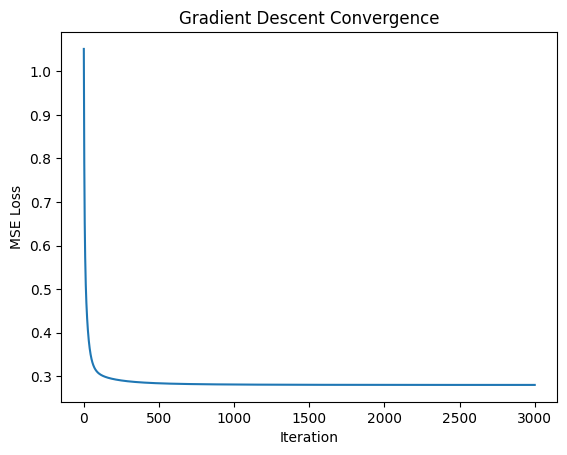

In [32]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Gradient Descent Convergence")
plt.show()

## Evaluate on Test Set

Evaluating Model Performance Using the R^2 Score. 

To assess how well our linear regression model generalizes to unseen data, we compute the coefficient of determination, commonly known as the R^2 score. This metric measures the proportion of variance in the target variable that is explained by the model.

The formula for R^2 is: 

$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$

This expression compares the model’s prediction error (numerator) with the error of a naive baseline model that always predicts the mean of 𝑦 (denominator).

A score of 1.0 means perfect prediction.

A score of 0.0 means the model performs no better than predicting the mean.

A negative score indicates that the model is worse than the mean predictor.

In [33]:
y_pred_test = X_test_b @ final_w
test_r2 = r2_score(y_test, y_pred_test)

print("Test R^2:", test_r2)

Test R^2: 0.7709119441491743


## Actual vs. Predicted Plot

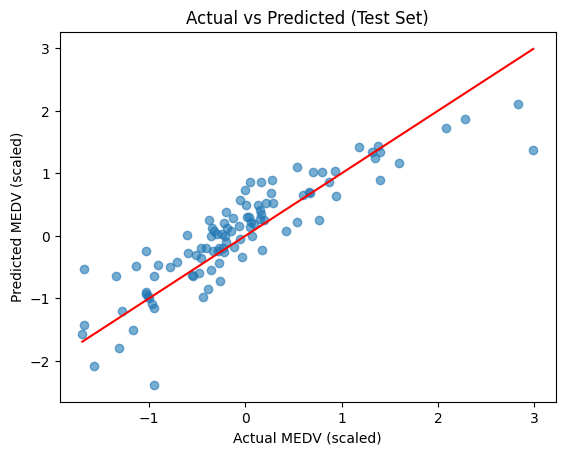

In [34]:
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red"
)
plt.xlabel("Actual MEDV (scaled)")
plt.ylabel("Predicted MEDV (scaled)")
plt.title("Actual vs Predicted (Test Set)")
plt.show()

## Summary and Analysis of Results

In this project, we trained a linear regression model on the Boston Housing dataset using gradient descent implemented entirely from scratch. After standardizing the features and target values, the gradient descent algorithm converged smoothly, as shown by the decreasing MSE loss curve. This indicates that the learning rate was appropriate and that the optimization landscape was well-behaved under feature scaling. The final weights produced by gradient descent generalized reasonably well to unseen data, achieving an R^2 score of approximately 0.77 on the test set. This means that the model was able to explain a substantial portion of the variance in housing prices, though not perfectly — which is expected, since linear regression cannot model complex nonlinear relationships present in real housing markets. The scatter plot of predicted versus actual values also shows a roughly linear trend with some spread around the ideal line, confirming both the strengths and limitations of a purely linear model. Overall, the results demonstrate that our custom gradient descent implementation is functioning correctly and is capable of fitting a meaningful predictive model when paired with appropriate preprocessing and properly tuned hyperparameters.